In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from __future__ import division

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


In [2]:
data_dir = 'data/'

In [3]:
draft = pd.read_csv(data_dir + 'draft_clean.csv', sep = '\t', index_col = 0)
ncaa = pd.read_csv(data_dir + 'ncaa_players_clean.csv', sep = '\t', index_col = 0)
ncaa_division = pd.read_csv(data_dir + 'ncaa_divisions.csv')

In [4]:
draft['dummy'] = 1
print draft.head()
print draft.describe()


               namekeys                 Player  Year  Rd  Pk   Tm  dummy
0          masonplumlee          Mason Plumlee  2013   1  22  BRK      1
1            rudygobert            Rudy Gobert  2013   1  27  DEN      1
2           stevenadams           Steven Adams  2013   1  12  OKC      1
3  giannisantetokounmpo  Giannis Antetokounmpo  2013   1  15  MIL      1
4            codyzeller            Cody Zeller  2013   1   4  CHA      1
              Year          Rd          Pk  dummy
count   180.000000  180.000000  180.000000    180
mean   2014.000000    1.500000   30.500000      1
std       0.818774    0.501395   17.366409      0
min    2013.000000    1.000000    1.000000      1
25%    2013.000000    1.000000   15.750000      1
50%    2014.000000    1.500000   30.500000      1
75%    2015.000000    2.000000   45.250000      1
max    2015.000000    2.000000   60.000000      1


In [5]:
divs_only = ncaa_division[['school_id','year','Division']]
ncaa_divs = pd.merge(ncaa, divs_only, how = 'left', on = ['school_id','year'])

ncaa_divs.columns.values

array(['school_name', 'school_id', 'year', 'name', 'player_id',
       'class_year', 'season', 'position', 'height', 'games',
       'field_goals', 'field_goal_attempts', 'field_goal_percent',
       'three_pointers', 'three_pointer_attempts', 'three_pointer_percent',
       'free_throws', 'free_throw_attempts', 'free_throw_percent',
       'rebounds', 'rebounds_per_game', 'assists', 'assists_per_game',
       'blocks', 'blocks_per_game', 'steals', 'steals_per_game', 'points',
       'points_per_game', 'turnovers', 'turnovers_per_game', 'namekeys',
       'Division'], dtype=object)

In [6]:
ncaa_draft = pd.merge(ncaa_divs, draft, how = 'left', on = 'namekeys')

In [7]:
ncaa_draft['dummy'].fillna(0, inplace = True)
ncaa_draft['TS'] = ncaa_draft['points'] / (2 * (ncaa_draft['field_goal_attempts'] + 0.44 * ncaa_draft['free_throw_attempts']))
ncaa_draft['TS'].fillna(0, inplace = True)
ncaa_draft['3PAr'] = ncaa_draft['three_pointer_attempts']/ncaa_draft['field_goal_attempts']
ncaa_draft['3PAr'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['3PAr'].fillna(0, inplace = True)
ncaa_draft['FTr'] = ncaa_draft['free_throw_attempts']/ncaa_draft['field_goal_attempts']
ncaa_draft['FTr'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['FTr'].fillna(0, inplace = True)
ncaa_draft['turnovers_per_game'].fillna(0,inplace = True)
ncaa_draft['AST/TO'] = ncaa_draft['assists'] / ncaa_draft['turnovers']
ncaa_draft['AST/TO'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['AST/TO'].fillna(0, inplace = True)
ncaa_draft['PPP'] = ncaa_draft.points / (ncaa_draft.field_goal_attempts + ncaa_draft.free_throw_attempts)
ncaa_draft['PPP'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['PPP'].fillna(0, inplace = True)
ncaa_draft = pd.get_dummies(ncaa_draft, columns = ['Division'], prefix = 'is_Div')
ncaa_draft = pd.get_dummies(ncaa_draft, columns = ['class_year'], prefix = 'is')
ncaa_draft = pd.get_dummies(ncaa_draft, columns = ['position'], prefix = 'is')



In [8]:
ncaa_draft_dd = ncaa_draft.drop_duplicates(subset = ['namekeys'], keep = 'last')
height = pd.DataFrame(list(ncaa_draft_dd.height.str.split('-')))
height.columns = ['foot','inch']
height[['foot','inch']] = height[['foot','inch']].replace('',0)
height[['foot','inch']] = height[['foot','inch']].astype(int)
height['foot'] = height['foot'] * [12]
height['total_height'] = height['foot'] + height['inch']
height.head()
ncaa_draft_dd = ncaa_draft_dd.reset_index()
ncaa_draft_dd = ncaa_draft_dd.drop('index', 1)

In [9]:
ncaa_draft_dd = ncaa_draft_dd.join(height['total_height'])

In [10]:
drafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 1]
undrafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 0]
draft_train = drafted.loc[np.random.choice(drafted.index, 137, replace=False)]
undraft_train = undrafted.loc[np.random.choice(undrafted.index, (137*5), replace = False)]

In [11]:
frames = [draft_train, undraft_train]
ncaa_bal = pd.concat(frames) 
ncaa_bal.columns.values

array(['school_name', 'school_id', 'year', 'name', 'player_id', 'season',
       'height', 'games', 'field_goals', 'field_goal_attempts',
       'field_goal_percent', 'three_pointers', 'three_pointer_attempts',
       'three_pointer_percent', 'free_throws', 'free_throw_attempts',
       'free_throw_percent', 'rebounds', 'rebounds_per_game', 'assists',
       'assists_per_game', 'blocks', 'blocks_per_game', 'steals',
       'steals_per_game', 'points', 'points_per_game', 'turnovers',
       'turnovers_per_game', 'namekeys', 'Player', 'Year', 'Rd', 'Pk',
       'Tm', 'dummy', 'TS', '3PAr', 'FTr', 'AST/TO', 'PPP', 'is_Div_1.0',
       'is_Div_2.0', 'is_Div_3.0', 'is_Fr.', 'is_Jr.', 'is_So.', 'is_Sr.',
       'is_C', 'is_F', 'is_G', 'total_height'], dtype=object)

In [13]:
X_cols = ['is_Fr.','is_So.','is_Sr.',
          'field_goals', 'field_goal_attempts', 'field_goal_percent',
          'three_pointers', 'three_pointer_attempts', 'three_pointer_percent',
          'free_throws', 'free_throw_attempts', 'free_throw_percent',
          'rebounds', 'rebounds_per_game', 'assists', 'assists_per_game',
          'blocks', 'blocks_per_game', 'steals', 'steals_per_game', 'points',
          'points_per_game', 'turnovers', 'turnovers_per_game',
          'TS', 'AST/TO','PPP','total_height','is_Div_1.0','is_Div_2.0']


clf_features = ['is_Fr.',
                'field_goal_percent','three_pointer_percent','free_throw_percent',
                'rebounds_per_game', 'assists_per_game',
                'blocks_per_game', 'steals_per_game', 
                'points_per_game', 'turnovers_per_game',
                'TS', 'AST/TO','PPP','total_height','is_Div_1.0','3PAr', 'FTr']

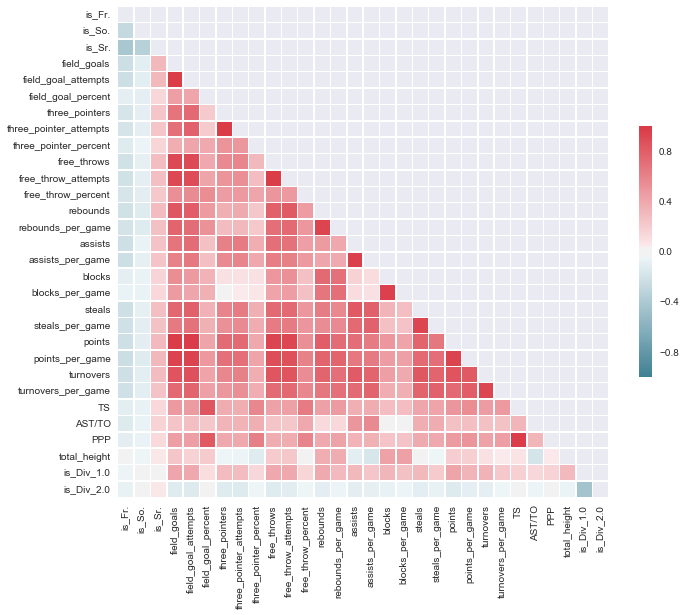

In [21]:
# Compute the correlation matrix
corr = ncaa_bal[X_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


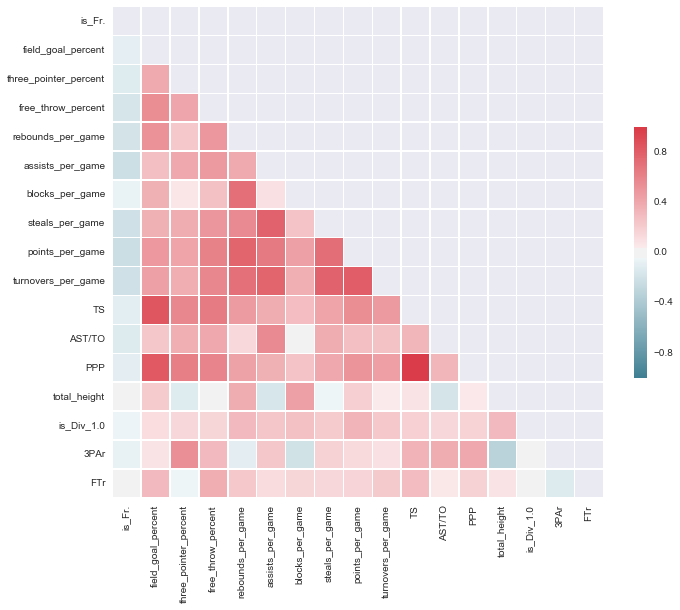

In [22]:
# Compute the correlation matrix
corr = ncaa_bal[clf_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [23]:
X = ncaa_bal[clf_features]
y = ncaa_bal['dummy']

X_t, X_tt, y_t, y_tt = cross_validation.train_test_split(X,y, test_size = .2)

X_all = ncaa_draft_dd[clf_features]
y_all = ncaa_draft_dd['dummy']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size = .2)



In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual = False),threshold = 'median')),
  ('classification', linear_model.LogisticRegression())
])
clf.fit(X_t, y_t)
clf.score(X_t, y_t)
support = clf.named_steps['feature_selection'].get_support()
coefs = clf.named_steps['classification'].coef_

support_list = pd.DataFrame(clf_features, support)
support_list = support_list.reset_index()
support_list.columns = ['selected','feature']
cols = ['feature','selected']
support_list = support_list[cols]

print "Features Selected:"
print support_list[support_list.selected == True]

X_n_cols = support_list[support_list.selected == True]
X_n_cols = X_n_cols['feature']
xlist = X_n_cols.values.T.tolist()

Features Selected:
               feature selected
0               is_Fr.     True
3   free_throw_percent     True
5     assists_per_game     True
6      blocks_per_game     True
9   turnovers_per_game     True
11              AST/TO     True
12                 PPP     True
14          is_Div_1.0     True
16                 FTr     True


In [25]:
print "Feature Coefficients:"
coef_list = pd.DataFrame(xlist, coefs[0])
coef_list = coef_list.reset_index()
coef_list.columns = ['coefficients','feature']
cols = ['feature','coefficients']
coef_list = coef_list[cols]
print coef_list

scores = cross_validation.cross_val_score(clf, X_t, y_t, cv = 10)
print "Feature Reduced Logistic Regression:", scores.mean()

print "Confusion Matrix and Report for Balanced Test Set:"
print metrics.confusion_matrix(y_tt, clf.predict(X_tt))
print metrics.classification_report(y_tt, clf.predict(X_tt))


Feature Coefficients:
              feature  coefficients
0              is_Fr.      0.347964
1  free_throw_percent     -0.168896
2    assists_per_game      0.846485
3     blocks_per_game      1.490534
4  turnovers_per_game     -0.110892
5              AST/TO     -0.631479
6                 PPP      0.480937
7          is_Div_1.0      2.997401
8                 FTr     -0.008067
Feature Reduced Logistic Regression: 0.911792088509
Confusion Matrix and Report for Balanced Test Set:
[[129   5]
 [ 13  18]]
             precision    recall  f1-score   support

        0.0       0.91      0.96      0.93       134
        1.0       0.78      0.58      0.67        31

avg / total       0.88      0.89      0.88       165



In [26]:
forest = RandomForestClassifier(n_estimators=250, max_features = 'auto',
                                random_state=0, max_depth=None,
                                )
forest.fit(X_t, y_t)
scores = cross_validation.cross_val_score(forest, X_t, y_t, cv = 10)
print "RandomForestClassifier:", scores.mean()
print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_tt, forest.predict(X_tt))
print metrics.classification_report(y_tt, forest.predict(X_tt))

#Forest Importances
importances = forest.fit(X_tt, y_tt).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking

X_cols_rf = []
for i in range(0,len(indices)):
    X_cols_rf.append(clf_features[indices[i]])

print("Random Forest Feature ranking:")
for f in range(len(X_cols_rf)):
    print("%d. %s (%f)" % (f + 1, X_cols_rf[f], importances[indices[f]]))


RandomForestClassifier: 0.951257349616
RandomForestClassifier CM:
[[130   4]
 [ 11  20]]
             precision    recall  f1-score   support

        0.0       0.92      0.97      0.95       134
        1.0       0.83      0.65      0.73        31

avg / total       0.91      0.91      0.90       165

Random Forest Feature ranking:
1. is_Div_1.0 (0.140261)
2. points_per_game (0.127851)
3. steals_per_game (0.106627)
4. rebounds_per_game (0.098382)
5. total_height (0.083398)
6. blocks_per_game (0.072214)
7. assists_per_game (0.060735)
8. turnovers_per_game (0.056542)
9. TS (0.048973)
10. PPP (0.032589)
11. AST/TO (0.031478)
12. field_goal_percent (0.028267)
13. FTr (0.027710)
14. 3PAr (0.024724)
15. free_throw_percent (0.022829)
16. three_pointer_percent (0.022533)
17. is_Fr. (0.014888)


In [27]:
ada = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.05, random_state = 0)
ada.fit(X_t,y_t)
scores = cross_validation.cross_val_score(ada, X_t, y_t)
print "AdaBoostClassifier:", scores.mean()
print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_tt, ada.predict(X_tt))
print metrics.classification_report(y_tt, ada.predict(X_tt))


#Forest Importances
importances = ada.fit(X_tt, y_tt).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

    
X_cols_ab = []
for i in range(0,len(indices)):
    X_cols_ab.append(clf_features[indices[i]])

print("AdaBoost Feature ranking:")
for f in range(len(X_cols_ab)):
    print("%d. %s (%f)" % (f + 1, X_cols_ab[f], importances[indices[f]]))


AdaBoostClassifier: 0.951286206288
AdaBoostClassifier CM:
[[129   5]
 [ 10  21]]
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.95       134
        1.0       0.81      0.68      0.74        31

avg / total       0.91      0.91      0.91       165

AdaBoost Feature ranking:
1. total_height (0.172000)
2. points_per_game (0.164000)
3. is_Div_1.0 (0.156000)
4. TS (0.136000)
5. PPP (0.112000)
6. steals_per_game (0.064000)
7. 3PAr (0.052000)
8. free_throw_percent (0.036000)
9. FTr (0.032000)
10. blocks_per_game (0.028000)
11. AST/TO (0.028000)
12. assists_per_game (0.020000)
13. turnovers_per_game (0.000000)
14. rebounds_per_game (0.000000)
15. three_pointer_percent (0.000000)
16. field_goal_percent (0.000000)
17. is_Fr. (0.000000)


In [28]:
gbc = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250, random_state = 0)

gbc.fit(X_t,y_t)
scores = cross_validation.cross_val_score(gbc, X_t, y_t, cv = 10)
print "GradientBoostingClassifier:", scores.mean()
print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_tt, gbc.predict(X_tt))
print metrics.classification_report(y_tt, gbc.predict(X_tt))


#Gradient Boosting Importances
importances = gbc.fit(X_tt, y_tt).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

X_cols_gb = []
for i in range(0,len(indices)):
    X_cols_gb.append(clf_features[indices[i]])


print("Gradient Boosting Feature ranking:")
for f in range(len(X_cols_gb)):
    print("%d. %s (%f)" % (f + 1, X_cols_gb[f], importances[indices[f]]))


GradientBoostingClassifier: 0.939019587378
GradientBoostingClassifier CM:
[[129   5]
 [  9  22]]
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.95       134
        1.0       0.81      0.71      0.76        31

avg / total       0.91      0.92      0.91       165

Gradient Boosting Feature ranking:
1. points_per_game (0.171426)
2. total_height (0.155514)
3. blocks_per_game (0.089323)
4. steals_per_game (0.081246)
5. FTr (0.074615)
6. is_Div_1.0 (0.072553)
7. rebounds_per_game (0.062035)
8. PPP (0.058775)
9. TS (0.050120)
10. AST/TO (0.042842)
11. is_Fr. (0.042226)
12. assists_per_game (0.027339)
13. turnovers_per_game (0.021958)
14. 3PAr (0.015465)
15. field_goal_percent (0.014971)
16. free_throw_percent (0.014658)
17. three_pointer_percent (0.004935)


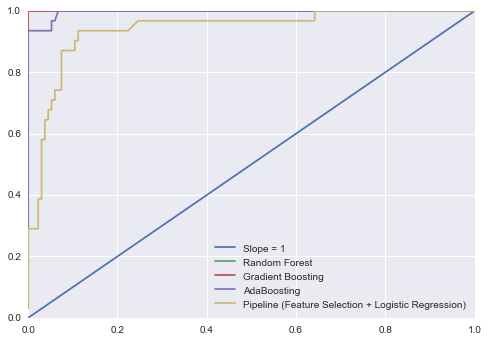

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_tt, forest.predict_proba(X_tt)[:,1])
plt_plt = plt.plot(fpr, fpr, label = 'Slope = 1')
forest_plt = plt.plot(fpr, tpr, label = 'Random Forest')

fpr, tpr, thresholds = metrics.roc_curve(y_tt, gbc.predict_proba(X_tt)[:,1])
gbc_plt = plt.plot(fpr, tpr, label = 'Gradient Boosting')

fpr, tpr, thresholds = metrics.roc_curve(y_tt, ada.predict_proba(X_tt)[:,1])
ada_plt = plt.plot(fpr, tpr, label = 'AdaBoosting')

fpr, tpr, thresholds = metrics.roc_curve(y_tt, clf.predict_proba(X_tt)[:,1])
clf_plt = plt.plot(fpr, tpr, label = 'Pipeline (Feature Selection + Logistic Regression)')


plt.legend(loc='lower right')


In [30]:
print "Confusion Matrix and Report for Unbalanced Sample:"
print metrics.confusion_matrix(y_all, clf.predict(X_all))
print metrics.classification_report(y_all, clf.predict(X_all))

print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_all, forest.predict(X_all))
print metrics.classification_report(y_all, forest.predict(X_all))

print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_all, gbc.predict(X_all))
print metrics.classification_report(y_all, gbc.predict(X_all))

print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_all, ada.predict(X_all))
print metrics.classification_report(y_all, ada.predict(X_all))

Confusion Matrix and Report for Unbalanced Sample:
[[28326   844]
 [   46    91]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     29170
        1.0       0.10      0.66      0.17       137

avg / total       0.99      0.97      0.98     29307

RandomForestClassifier CM:
[[28263   907]
 [   20   117]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     29170
        1.0       0.11      0.85      0.20       137

avg / total       1.00      0.97      0.98     29307

GradientBoostingClassifier CM:
[[28070  1100]
 [   25   112]]
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     29170
        1.0       0.09      0.82      0.17       137

avg / total       0.99      0.96      0.98     29307

AdaBoostClassifier CM:
[[28183   987]
 [   30   107]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98   

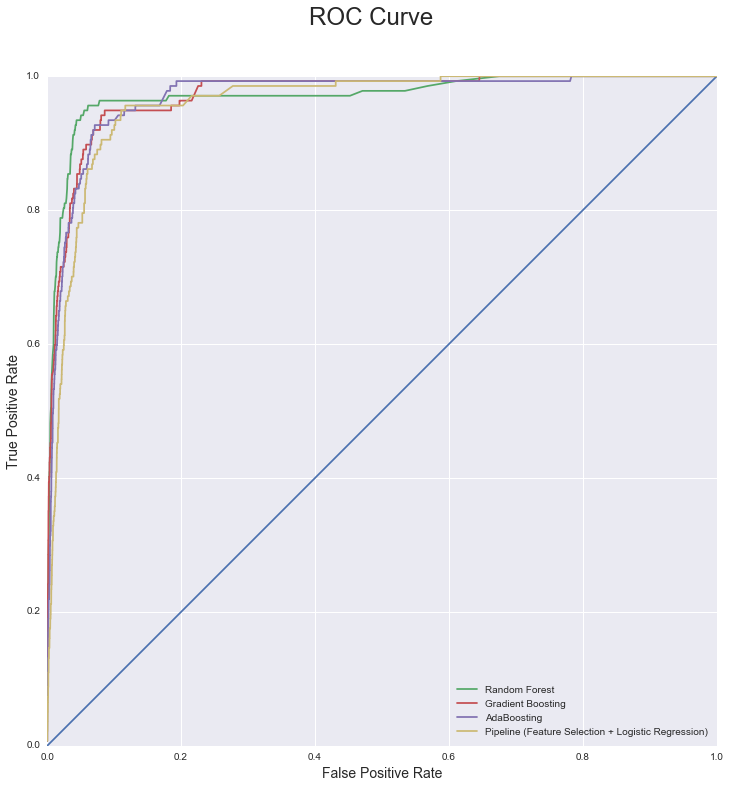

In [47]:
plt.figure(figsize=(12,12))

fpr, tpr, thresholds = metrics.roc_curve(y_all, forest.predict_proba(X_all)[:,1])

plt_plt = plt.plot(fpr, fpr)
forest_plt = plt.plot(fpr, tpr, label = 'Random Forest')

fpr, tpr, thresholds = metrics.roc_curve(y_all, gbc.predict_proba(X_all)[:,1])
gbc_plt = plt.plot(fpr, tpr, label = 'Gradient Boosting')

fpr, tpr, thresholds = metrics.roc_curve(y_all, ada.predict_proba(X_all)[:,1])
ada_plt = plt.plot(fpr, tpr, label = 'AdaBoosting')

fpr, tpr, thresholds = metrics.roc_curve(y_all, clf.predict_proba(X_all)[:,1])
clf_plt = plt.plot(fpr, tpr, label = 'Pipeline (Feature Selection + Logistic Regression)')

plt.suptitle('ROC Curve', fontsize=24)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.legend(loc='lower right')



In [48]:
draft2 = pd.read_csv(data_dir + '2012draft_clean.csv', sep = '\t', index_col = 0)
ncaa2 = pd.read_csv(data_dir + 'ncaa_players_clean2012.csv', sep = '\t', index_col = 0)
draft2['dummy'] = 1

In [49]:
ncaa_divs2 = pd.merge(ncaa2, divs_only, how = 'left', on = ['school_id','year'])

In [50]:
ncaa_draft2 = pd.merge(ncaa_divs2, draft2, how = 'left', on = 'namekeys')


In [51]:
ncaa_draft2['dummy'].fillna(0, inplace = True)
ncaa_draft2['TS'] = ncaa_draft2['points'] / (2 * (ncaa_draft2['field_goal_attempts'] + 0.44 * ncaa_draft2['free_throw_attempts']))
ncaa_draft2['TS'].fillna(0, inplace = True)
ncaa_draft2['3PAr'] = ncaa_draft2['three_pointer_attempts']/ncaa_draft2['field_goal_attempts']
ncaa_draft2['3PAr'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft2['3PAr'].fillna(0, inplace = True)
ncaa_draft2['FTr'] = ncaa_draft2['free_throw_attempts']/ncaa_draft2['field_goal_attempts']
ncaa_draft2['FTr'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft2['FTr'].fillna(0, inplace = True)
ncaa_draft2['turnovers_per_game'].fillna(0,inplace = True)
ncaa_draft2['AST/TO'] = ncaa_draft2['assists']/ncaa_draft2['turnovers']
ncaa_draft2['AST/TO'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft2['AST/TO'].fillna(0, inplace = True)
ncaa_draft2['PPP'] = ncaa_draft2.points / (ncaa_draft2.field_goal_attempts + ncaa_draft2.free_throw_attempts)
ncaa_draft2['PPP'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft2['PPP'].fillna(0, inplace = True)
ncaa_draft2 = pd.get_dummies(ncaa_draft2, columns = ['Division'], prefix = 'is_Div')
ncaa_draft2 = pd.get_dummies(ncaa_draft2, columns = ['class_year'], prefix = 'is')


ncaa_draft_dd2 = ncaa_draft2.drop_duplicates(subset = ['namekeys'], keep = 'last')
height = pd.DataFrame(list(ncaa_draft_dd2.height.str.split('-')))
height.columns = ['foot','inch']
height[['foot','inch']] = height[['foot','inch']].replace('',0)
height[['foot','inch']] = height[['foot','inch']].astype(int)
height['foot'] = height['foot'] * [12]
height['total_height'] = height['foot'] + height['inch']
height.head()
ncaa_draft_dd2 = ncaa_draft_dd2.reset_index()
ncaa_draft_dd2 = ncaa_draft_dd2.drop('index', 1)
ncaa_draft_dd2 = ncaa_draft_dd2.join(height['total_height'])


In [52]:
X_all2 = ncaa_draft_dd2[clf_features]
y_all2 = ncaa_draft_dd2['dummy']
ncaa_draft_dd2.shape

(16151, 50)

In [53]:
print "Confusion Matrix and Report for Unbalanced Sample:"
print metrics.confusion_matrix(y_all2, clf.predict(X_all2))
print metrics.classification_report(y_all2, clf.predict(X_all2))

print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_all2, forest.predict(X_all2))
print metrics.classification_report(y_all2, forest.predict(X_all2))

print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_all2, gbc.predict(X_all2))
print metrics.classification_report(y_all2, gbc.predict(X_all2))

print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_all2, ada.predict(X_all2))
print metrics.classification_report(y_all2, ada.predict(X_all2))

Confusion Matrix and Report for Unbalanced Sample:
[[15578   525]
 [   18    30]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     16103
        1.0       0.05      0.62      0.10        48

avg / total       1.00      0.97      0.98     16151

RandomForestClassifier CM:
[[15624   479]
 [   12    36]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     16103
        1.0       0.07      0.75      0.13        48

avg / total       1.00      0.97      0.98     16151

GradientBoostingClassifier CM:
[[15518   585]
 [   12    36]]
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98     16103
        1.0       0.06      0.75      0.11        48

avg / total       1.00      0.96      0.98     16151

AdaBoostClassifier CM:
[[15540   563]
 [   10    38]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98   

In [54]:
dray = ncaa_draft_dd2[ncaa_draft_dd2.namekeys == 'draymondgreen']

In [55]:
print "Model Probability of Getting Drafted: \n" 

prob = clf.predict_proba(X_all2.iloc[dray.index])
print "Feature Reduced Logistic Regression: ", prob[0][1]

prob = forest.predict_proba(X_all2.iloc[dray.index])
print "Random Forest Classifier: ", prob[0][1]

prob = gbc.predict_proba(X_all2.iloc[dray.index])
print "Gradient Boosting Classifier: ", prob[0][1]

prob = ada.predict_proba(X_all2.iloc[dray.index])
print "AdaBoosting Classifier: ", prob[0][1]


Model Probability of Getting Drafted: 

Feature Reduced Logistic Regression:  0.828171884835
Random Forest Classifier:  0.92
Gradient Boosting Classifier:  0.998581073001
AdaBoosting Classifier:  0.542705914745


In [437]:
display_vars = ['school_name','name', 'position','height','is_Sr.',
                'field_goal_percent','three_pointer_percent','free_throw_percent',
                'rebounds_per_game', 'assists_per_game',
                'blocks_per_game', 'steals_per_game', 
                'points_per_game', 'turnovers_per_game',
                'TS', 'AST/TO','PPP','total_height','is_Div_1.0','3PAr', 'FTr']
dray[display_vars].T

,8216
school_name,Michigan St.
name,Draymond Green
position,F
height,6-7
is_Sr.,1
field_goal_percent,0.449
three_pointer_percent,0.388
free_throw_percent,0.723
rebounds_per_game,10.649
assists_per_game,3.811


In [56]:
from sklearn.externals.six import StringIO
from sklearn import tree

dtree = tree.DecisionTreeClassifier(random_state=0)
dtree = dtree.fit(X_t, y_t)
scores = cross_validation.cross_val_score(dtree, X_t, y_t, cv = 10)
print "Decision TreeClassifier:", scores.mean()
print "Decision Tree CM:"
print metrics.confusion_matrix(y_all2, dtree.predict(X_all2))
print metrics.classification_report(y_all2, dtree.predict(X_all2))

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(dtree, out_file=f, 
                            feature_names=clf_features, 
                            class_names=['0','1'],
                            rounded=True, filled=True)

Decision TreeClassifier: 0.936034512751
Decision Tree CM:
[[15601   502]
 [   11    37]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     16103
        1.0       0.07      0.77      0.13        48

avg / total       1.00      0.97      0.98     16151



In [465]:
!dot -Tpng tree.dot > tree.png